In [18]:
# !pip install statsforecast
# https://stackoverflow.com/questions/72636498/error-pip-installing-fbprophet-pystan-installed-fine-i-tried-different-version
# !pip install pystan==2.18.0.0
# !pip install fbprophet==0.6
# !pip install prophet
# set SETUPTOOLS_USE_DISTUTILS=stdlib
# https://pypi.org/project/pycausalimpact/
# !pip install pycausalimpact
# !pip install dtw
# !pip install fastdtw #fastdtw-0.3.4
# https://stackoverflow.com/questions/52479046/different-results-and-performances-with-different-libraries

     |████████████████████████████████| 133 kB 1.3 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp37-cp37m-linux_x86_64.whl size=509845 sha256=7e21748410a34929fb7a77d07987d09cf8554c234d55888fdab7faa9389eb8b6
  Stored in directory: /home/jupyter/.cache/pip/wheels/a2/da/8c/2d1b9b233595056f05e59156bb555f7277b88beb385605de16
Successfully built fastdtw


# Documenation Steps

###  Assess the impact of a marketing campaign for the targeted brand (Chex Mix) using **Fetch** transactional data without a control population
### Methods:
Utilize historical data (1-2 years) for Chex Mix and similar control brands.
Identify control brands with similar trends using correlation, Euclidean distance, etc.

#### Causal Impact Analysis:
Utilize the "causal impact" library for causal analysis.
Analyze whether the campaign had a significant effect on sales by comparing pre-campaign and post-campaign periods.

#### Forecasting Method:
Project sales of both the target brand and control brands, considering a certain confidence interval.
Aggregate weekly sales data, including predicted sales.
Calculate the delta between actual and predicted sales for target brand and compare it with control brands.
If the delta shows a positive deviation, it indicates a potential effect of the campaign on target brand sales.


#### Statistical Regression Analysis (Add-on):

Conduct a regression analysis on target brand sales data, treating "marketing" as an independent binary variable.
Assign a value of 1 during the marketing period and 0 otherwise.
Run the regression to test the hypothesis of whether the marketing campaign had a significant impact on target brand sales.
Analyze the regression results to determine the strength and significance of the relationship between the marketing campaign and target brand sales.


In [46]:
import time
from datetime import datetime, timedelta
from copy import deepcopy
from functools import partial
from multiprocessing import Pool, cpu_count

import numpy as np
import pandas as pd
from dtw import dtw
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
# from neuralforecast.losses.numpy import mse
from prophet import Prophet
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from causalimpact import CausalImpact
from statsmodels.tsa.stattools import grangercausalitytests


import matplotlib.pyplot as plt


#BigQuery & Google CLoud Storage
import google.auth
from google.oauth2 import service_account
from google.cloud.logging import Client
from google.cloud.logging.handlers import CloudLoggingHandler
from google.cloud import bigquery
from google.auth import compute_engine
from google.cloud import storage

bq_client = bigquery.Client()
storage_client = storage.Client()    
print("Client creating using default project: {}".format(bq_client.project))

Client creating using default project: marketing-pma-dna-dev-3bef5b


In [47]:
def load_sql(client, project_id, dataset_id, table_id, where_clause, cols=" * "):
    """
    Load data from a BigQuery table into a Pandas DataFrame in batches.

    Parameters:
    - client (google.cloud.bigquery.client.Client):  BigQuery client .
    - project_id (str):  Google Cloud project related to BigQuery dataset.
    - dataset_id (str):  BigQuery dataset containing the table.
    - table_id (str):    BigQuery table 
    - where_clause (str): An optional WHERE clause for filtering rows (e.g., " WHERE column_name = 'value' ").
    - cols (str, optional): A comma-separated string of column names to select or * (All Columns) .  Default is *.
    - batch_size (int, optional): The number of rows to fetch in each batch. Default 1000000.

    Returns:
    - pd.DataFrame: A Pandas DataFrame containing the fetched data.
    """
    table_ref = f"{project_id}.{dataset_id}.{table_id}"
    
    # Initialize an empty DataFrame to store the results
    result_dataframe = pd.DataFrame()


    query = f"""
        SELECT {cols}
        FROM `{table_ref}`
        {where_clause}
        LIMIT 1000000
    """
        
    batch_df = client.query(query).to_dataframe()
    
    return batch_df


def remove_timezone(dt):
   
    #  `dt` is a python datetime 
    return dt.replace(tzinfo=None)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



def find_controls_productline_match(target_brand_data, other_brands_data):
    scaler = MinMaxScaler()  
    target_brand_data_normalized = scaler.fit_transform(target_brand_data.values.reshape(-1, 1))  # Normalize target brand data

    controls_match = {}
    for brand, data in other_brands_data.items():
        data_normalized = scaler.transform(data.values.reshape(-1, 1))  # Normalize control brand data
        print(brand)
        distance, _, _ ,_ = dtw(target_brand_data_normalized, data_normalized, dist=lambda x, y: np.sqrt(np.sum((x - y) ** 2)))
        
        #  correlation 
        correlation = np.corrcoef(target_brand_data, data)[0, 1]
        
        controls_match[brand] = {'DTW Distance': distance, 'Correlation': correlation}

                
        
        
    return controls_match
    

In [48]:
def calculate_causal_impact(dataframe, pre_period, post_period):
    
    
    
    causal_impact = CausalImpact(dataframe, pre_period, post_period)

    return causal_impact

In [49]:
# chex_mix_seed_selective_brands_allsales   -- total level
# chex_mix_seed_selective_brands_allgroups  -- seed level
# chex_mix_seed_selective_brands_groupcode  -- seed level with groups


table="chex_mix_seed_selective_brands_allgroups"

main_dataframe = load_sql(bq_client, "marketing-pma-dna-dev-3bef5b",
                                       "transient",
                                        table,
                                       "  ORDER BY receipt_date", cols=" * ") #WHERE receipt_date<='2023-09-31' 

In [50]:
main_dataframe['receipt_date'] = main_dataframe['receipt_date'].apply(remove_timezone)

In [51]:
main_dataframe.head()

,receipt_date,weekend,MOTTS,NV PROTEIN BAR,NV CRUNCHY BAR,GMI CEREAL BARS,LARABAR ORIG,GARDETTOS,MUDDY BUDDIES,BUGLES,CHEX MIX
0,2022-01-01,1,218.67,144.91,316.63,306.00,95.53,248.97,135.27,152.43,969.84
1,2022-01-02,1,516.70,315.26,939.85,401.01,270.96,341.83,141.68,203.28,1399.96
2,2022-01-03,0,527.81,249.41,1024.19,413.94,137.30,397.32,197.72,217.00,1238.09
3,2022-01-04,0,453.23,353.58,824.84,346.79,376.04,435.45,271.32,250.49,1445.96
4,2022-01-05,0,362.71,271.17,991.70,457.01,243.48,380.73,114.30,270.38,1900.17


In [52]:
main_dataframe['receipt_date'] = pd.to_datetime(main_dataframe['receipt_date'])
main_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   receipt_date     729 non-null    datetime64[ns]
 1   weekend          729 non-null    int64         
 2   MOTTS            729 non-null    float64       
 3   NV PROTEIN BAR   728 non-null    float64       
 4   NV CRUNCHY BAR   729 non-null    float64       
 5   GMI CEREAL BARS  729 non-null    float64       
 6   LARABAR ORIG     728 non-null    float64       
 7   GARDETTOS        729 non-null    float64       
 8   MUDDY BUDDIES    729 non-null    float64       
 9   BUGLES           729 non-null    float64       
 10  CHEX MIX         729 non-null    float64       
dtypes: datetime64[ns](1), float64(9), int64(1)
memory usage: 62.8 KB


In [56]:
df=main_dataframe.copy()

In [57]:
df = df.drop(["MOTTS","NV PROTEIN BAR","NV CRUNCHY BAR","GMI CEREAL BARS","LARABAR ORIG","weekend"], axis=1)

In [58]:

df = df[['receipt_date','GARDETTOS','MUDDY BUDDIES','BUGLES','CHEX MIX']]
# if group
# df = df[['receipt_date','group_code','GARDETTOS','MUDDY BUDDIES','BUGLES','CHEX MIX']]
df.tail()

,receipt_date,GARDETTOS,MUDDY BUDDIES,BUGLES,CHEX MIX
724,2023-12-26,414.62,315.13,276.74,1359.49
725,2023-12-27,443.89,213.31,328.28,1269.94
726,2023-12-28,577.86,293.07,278.27,1717.38
727,2023-12-29,1000.72,466.93,586.43,2544.26
728,2023-12-30,866.72,357.35,564.87,2470.23


In [59]:
df.rename(columns=lambda x: x.replace(' ', '_').lower(), inplace=True)
df.head()

,receipt_date,gardettos,muddy_buddies,bugles,chex_mix
0,2022-01-01,248.97,135.27,152.43,969.84
1,2022-01-02,341.83,141.68,203.28,1399.96
2,2022-01-03,397.32,197.72,217.00,1238.09
3,2022-01-04,435.45,271.32,250.49,1445.96
4,2022-01-05,380.73,114.30,270.38,1900.17


In [61]:
# grangercausalitytests(df[['chex_mix', 'larabar_orig']], [1])

In [125]:
grangercausalitytests(df[['nv_crunchy_bar', 'chex_mix']], [1])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.1685 , p=0.0000  , df_denom=725, df_num=1
ssr based chi2 test:   chi2=19.2478 , p=0.0000  , df=1
likelihood ratio test: chi2=18.9978 , p=0.0000  , df=1
parameter F test:         F=19.1685 , p=0.0000  , df_denom=725, df_num=1


{1: ({'ssr_ftest': (19.168507394054913, 1.3728619658516972e-05, 725.0, 1),
   'ssr_chi2test': (19.247825355685485, 1.1480106964336072e-05, 1),
   'lrtest': (18.997773534123553, 1.3087107182800653e-05, 1),
   'params_ftest': (19.168507394036446, 1.3728619658647442e-05, 725.0, 1.0)},
   array([[0., 1., 0.]])])}

In [92]:
group = 'group_code'
group_filter = "A_<10"
# "F_50+" 
# "E_34-49"
# "D_25-33"
# "C_18 to 24"
# "B_10 to 17"
# "A_<10"

In [93]:
df = df[df[group]== group_filter].reset_index(drop=True)
df=df.fillna(value=0)
df = df.drop([group], axis=1)
df.tail()

,receipt_date,gardettos,muddy_buddies,bugles,chex_mix
724,2023-12-26,149.16,132.19,109.28,477.23
725,2023-12-27,134.98,67.31,81.15,528.18
726,2023-12-28,233.22,107.44,93.68,693.75
727,2023-12-29,335.93,155.49,232.55,956.05
728,2023-12-30,251.02,81.00,164.14,893.77


# For Sales Trend Plot purpose

In [63]:
df['Month'] = df['receipt_date'].dt.to_period('M')
grouped_df = df.groupby('Month').sum()
# grouped_df.index = pd.to_datetime(grouped_df.index)
grouped_df.index = pd.to_datetime(grouped_df.index.to_timestamp())
grouped_df.tail()

,gardettos,muddy_buddies,bugles,chex_mix
Month,,,,
2023-08-01,9905.55,4039.11,6642.46,31065.08
2023-09-01,7953.69,2999.55,6302.10,22198.38
2023-10-01,9500.27,4202.77,6439.49,33170.41
2023-11-01,8132.19,5756.48,5552.40,30151.21
2023-12-01,10108.04,8303.64,6907.33,30034.33


In [237]:
# normalized_df = (df - df.min()) / (df.max() - df.min())
normalized_df = (grouped_df - grouped_df.min()) / (grouped_df.max() - grouped_df.min())

In [238]:
def plot_sales_trend(title,df,marketing_dt,cooloff_dt,limit=0,limit_date=""):

    # Plotting original sales data

    plt.figure(figsize=(20, 6))

    # df.index = pd.to_datetime(df.index)
    for col in df.columns:
        plt.plot(df.index, df[col], label=col)

    # Marking the date of marketing intervention
    marketing_date = pd.to_datetime(marketing_dt)
    plt.axvline(x=marketing_date - pd.Timedelta(days=5), color='red', linestyle='--', label='Marketing-Intervention')
    
    cooloff_date = pd.to_datetime(cooloff_dt)
    plt.axvline(x=cooloff_date - pd.Timedelta(days=10), color='pink', linestyle='--', label='Post-intervention sales period')

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(alpha=0.2)  # Set alpha parameter to make grid lines fainter
    if limit:
        plt.xlim(limit_date, df.index[-1])
    plt.show()


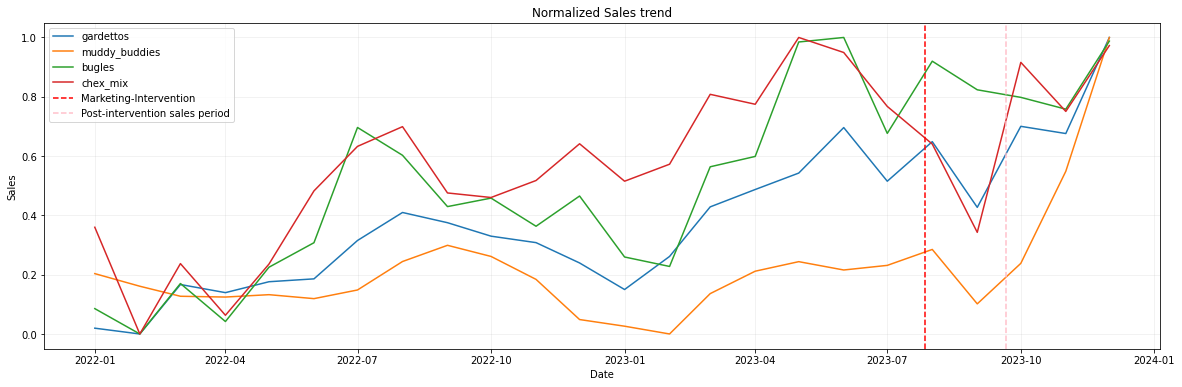

In [239]:
plot_sales_trend('Normalized Sales trend', normalized_df,marketing_dt='2023-08-01',cooloff_dt='2023-10-01',limit=0,limit_date=pd.to_datetime("2023-05-01"))

# For Causal Impact Analysis

In [62]:
df = df[df['receipt_date'] < '2023-09-25'] .copy()

In [63]:
df.head()

,receipt_date,gardettos,muddy_buddies,bugles,chex_mix
0,2022-01-01,248.97,135.27,152.43,969.84
1,2022-01-02,341.83,141.68,203.28,1399.96
2,2022-01-03,397.32,197.72,217.00,1238.09
3,2022-01-04,435.45,271.32,250.49,1445.96
4,2022-01-05,380.73,114.30,270.38,1900.17


In [64]:
targetBrand="chex_mix"
date_col= "receipt_date"

first_columns = [date_col,targetBrand] 
remaining_cols = [col for col in df.columns if col not in first_columns]
remaining_cols
new_columns_order = first_columns + remaining_cols
df = df[new_columns_order]
df=df.fillna(value=0)
df.head()

,receipt_date,chex_mix,gardettos,muddy_buddies,bugles
0,2022-01-01,969.84,248.97,135.27,152.43
1,2022-01-02,1399.96,341.83,141.68,203.28
2,2022-01-03,1238.09,397.32,197.72,217.00
3,2022-01-04,1445.96,435.45,271.32,250.49
4,2022-01-05,1900.17,380.73,114.30,270.38


In [65]:
date_col="receipt_date"
df = df.set_index([date_col])

In [66]:
df =df[["chex_mix","gardettos","bugles"]]

In [67]:
df.tail()

,chex_mix,gardettos,bugles
receipt_date,,,
2023-09-20,1182.23,364.57,344.52
2023-09-21,942.96,298.98,225.56
2023-09-22,1749.27,515.47,346.97
2023-09-23,1951.29,480.98,368.24
2023-09-24,959.93,506.76,268.34


In [68]:
pre_period = ['2022-01-01', '2023-07-25']
post_period = ['2023-07-26', '2023-09-24']

# causal_impact_result = calculate_causal_impact(df, pre_period, post_period)
causal_impact_result = CausalImpact(df, pre_period, post_period, alpha = 0.1, model_args={'fit_method':'hmc'}) 

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/optimizer.py:23: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: model_args, standardize, nseasons. After release 0.14, this will raise.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [69]:
causal_impact_result.model.parameters

{'irregular_var': 1, 'level_var': 1, 'reg_coeff': 2}

In [55]:
causal_impact_result.plot()

NameError: name 'causal_impact_result' is not defined

In [99]:
trial_df.head()

,chex_mix,gardettos,bugles
0,969.84,248.97,152.43
1,1399.96,341.83,203.28
2,1238.09,397.32,217.00
3,1445.96,435.45,250.49
4,1900.17,380.73,270.38


In [103]:
grangercausalitytests(trial_df[['chex_mix', 'bugles']], [1])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2804  , p=0.0706  , df_denom=628, df_num=1
ssr based chi2 test:   chi2=3.2961  , p=0.0694  , df=1
likelihood ratio test: chi2=3.2875  , p=0.0698  , df=1
parameter F test:         F=3.2804  , p=0.0706  , df_denom=628, df_num=1


{1: ({'ssr_ftest': (3.28044977968148, 0.0705873632628684, 628.0, 1),
   'ssr_chi2test': (3.2961207181194494, 0.06944370344867375, 1),
   'lrtest': (3.2875416968545323, 0.06980746567072844, 1),
   'params_ftest': (3.2804497796324528, 0.07058736326496122, 628.0, 1.0)},
   array([[0., 1., 0.]])])}

In [35]:
print(causal_impact_result.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    2125.25            129640.4
Prediction (s.d.)         2356.78 (168.6)    143763.57 (10284.88)
95% CI                    [2041.45, 2702.37] [124528.74, 164844.71]

Absolute effect (s.d.)    -231.53 (168.6)    -14123.17 (10284.88)
95% CI                    [-577.12, 83.8]    [-35204.31, 5111.66]

Relative effect (s.d.)    -9.82% (7.15%)     -9.82% (7.15%)
95% CI                    [-24.49%, 3.56%]   [-24.49%, 3.56%]

Posterior tail-area probability p: 0.08
Posterior prob. of a causal effect: 91.71%

For more details run the command: print(impact.summary('report'))


In [36]:
print(causal_impact_result.summary(output='report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 2125.25. In the absence of an
intervention, we would have expected an average response of 2356.78.
The 95% interval of this counterfactual prediction is [2041.45, 2702.37].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -231.53 with a 95% interval of
[-577.12, 83.8]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 129640.4.
Had the intervention not taken place, we would have expected
a sum of 143763.57. The 95% interval of this prediction is [124528.74, 164844.71].


The above results are given in terms of absolute numbers. In relative
terms, the response variable s

In [27]:
results = pd.DataFrame([],columns=['Evaluation','train_RMSE','test_RMSE','train_r2','test_r2'])


In [37]:
pre_period[0]
post_period[0]

'2023-07-26'

In [47]:
trial_df=df.copy()
trial_df=df.reset_index(drop=True)

In [69]:
trial_df.tail(61)

,chex_mix,gardettos,bugles
571,1435.54,549.50,301.60
572,1896.54,318.15,417.85
573,1792.44,604.04,407.35
574,1835.24,738.63,683.85
575,1395.39,532.57,422.64
...,...,...,...
627,1182.23,364.57,344.52
628,942.96,298.98,225.56
629,1749.27,515.47,346.97
630,1951.29,480.98,368.24


In [70]:
pre_period = [0,570]


post_period = [571,631]

In [61]:
    
# filter data frame of post_period because we won't use it in analysis
# wide_df = df.loc[pre_period[0]:(pre_period[1]),:]
wide_df = df.iloc[pre_period[0]:(pre_period[1]+1),:]
wide_df.tail()

,chex_mix,gardettos,bugles
receipt_date,,,
2023-07-21,3290.85,907.16,578.75
2023-07-22,3988.09,805.85,503.97
2023-07-23,3040.75,846.75,398.83
2023-07-24,2265.38,695.64,395.01
2023-07-25,2503.96,757.53,371.93


In [82]:
temp_wide_df = wide_df.copy()
# select a new random pre-period start date in the first 25% of the pre period
pre_start = int(np.random.choice(list(range(pre_period[0],int(pre_period[1] * .25)))))

# select a new random post-period start in the between the last 60% and 80% of the pre period
post_start = int(np.random.choice(list(range(int(.70*pre_period[1]),int(.85*pre_period[1])))))

pre_end = post_start - 1

# select a new random post-period end in the between the last 60% and 80% of the pre period

post_end = int(np.random.choice(list(range(int(.90*pre_period[1]),pre_period[1]))))

pre_obs = (pre_end-pre_start)
post_obs = (post_end-post_start)

print("Backtest Trial {}: pre-start {}, pre-end {}, post-start {}, post-end {}".format(4,pre_start,pre_end,post_start,post_end))

temp_wide_df = temp_wide_df.iloc[pre_start:(post_end+1),:]
temp_wide_df.reset_index(drop=True, inplace=True)



Backtest Trial 4: pre-start 125, pre-end 432, post-start 433, post-end 565


In [85]:
pre_obs +post_obs

439

In [83]:
temp_wide_df

,chex_mix,gardettos,bugles
0,1933.13,563.84,295.47
1,2182.94,551.24,448.70
2,1972.94,673.45,388.51
3,2002.06,448.32,333.68
4,2148.66,455.22,328.94
...,...,...,...
436,3117.41,948.02,401.32
437,2053.78,682.67,388.96
438,2009.97,752.52,358.66
439,3297.29,716.60,452.02


In [86]:
pre_start = 0
pre_end = pre_obs
post_start = pre_obs+1
post_end = pre_obs+1+post_obs

pre_period_new = [pre_start,pre_end]

post_period_new = [post_start,post_end]


In [88]:
post_period_new

[308, 440]

In [89]:

ci = CausalImpact(temp_wide_df, pre_period_new, post_period_new, alpha = 0.1, model_args={'fit_method':'hmc'})

/opt/conda/lib/python3.7/site-packages/statsmodels/base/optimizer.py:23: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: nseasons, model_args, standardize. After release 0.14, this will raise.
  FutureWarning


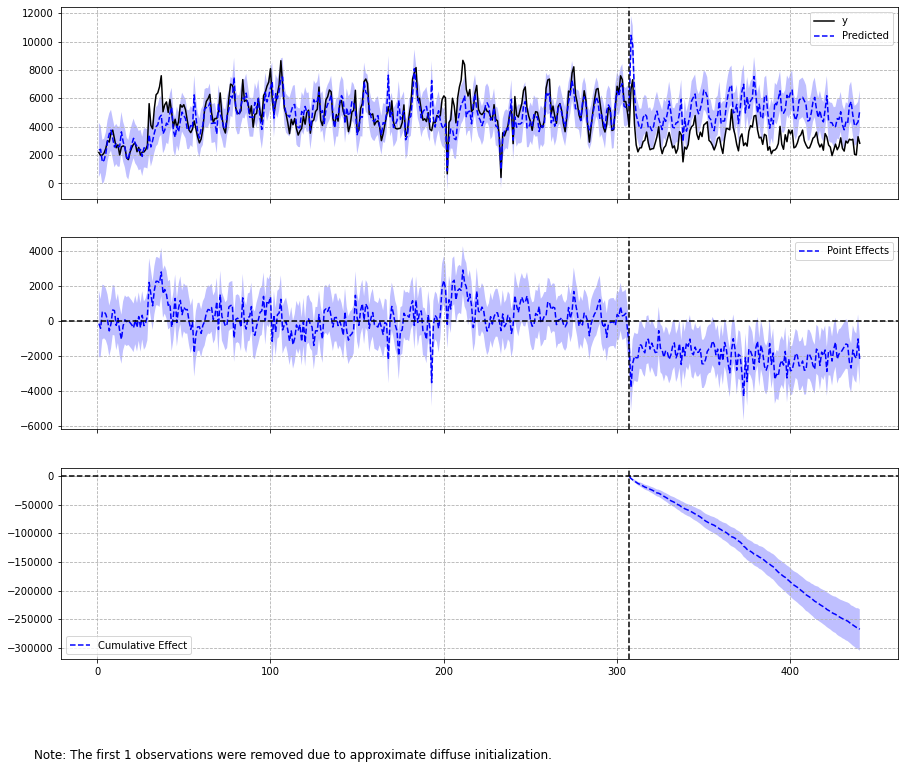

In [90]:
ci.plot()

In [91]:
ci.inferences

,post_cum_y,preds,post_preds,post_preds_lower,post_preds_upper,preds_lower,preds_upper,post_cum_pred,post_cum_pred_lower,post_cum_pred_upper,point_effects,point_effects_lower,point_effects_upper,post_cum_effects,post_cum_effects_lower,post_cum_effects_upper
0,NaN,2948.161299,NaN,NaN,NaN,-2.332191e+06,2.338087e+06,NaN,NaN,NaN,-1015.031299,-2.336154e+06,2.334124e+06,NaN,NaN,NaN
1,NaN,2354.913729,NaN,NaN,NaN,4.374604e+02,4.272367e+03,NaN,NaN,NaN,-171.973729,-2.089427e+03,1.745480e+03,NaN,NaN,NaN
2,NaN,2409.352561,NaN,NaN,NaN,7.486710e+02,4.070034e+03,NaN,NaN,NaN,-436.412561,-2.097094e+03,1.224269e+03,NaN,NaN,NaN
3,NaN,1513.350856,NaN,NaN,NaN,-5.246617e+01,3.079168e+03,NaN,NaN,NaN,488.709144,-1.077108e+03,2.054526e+03,NaN,NaN,NaN
4,NaN,1639.659112,NaN,NaN,NaN,1.234555e+02,3.155863e+03,NaN,NaN,NaN,509.000888,-1.007203e+03,2.025205e+03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,403366.46,4796.346366,4796.346366,3390.354739,6202.337993,3.390355e+03,6.202338e+03,663681.247775,630579.201302,700012.791942,-1678.936366,-3.084928e+03,-2.729447e+02,-260314.787775,-296646.331942,-227212.741302
437,405420.24,4066.940184,4066.940184,2660.669346,5473.211021,2.660669e+03,5.473211e+03,667748.187958,634549.767248,704111.663968,-2013.160184,-3.419431e+03,-6.068893e+02,-262327.947958,-298691.423968,-229129.527248
438,407430.21,4159.383867,4159.383867,2752.833874,5565.933860,2.752834e+03,5.565934e+03,671907.571826,638377.826184,708861.265699,-2149.413867,-3.555964e+03,-7.428639e+02,-264477.361826,-301431.055699,-230947.616184
439,410727.50,4342.635930,4342.635930,2935.806837,5749.465023,2.935807e+03,5.749465e+03,676250.207756,641703.895200,713380.208895,-1045.345930,-2.452175e+03,3.614832e+02,-265522.707756,-302652.708895,-230976.395200


In [ ]:
for i in list(range(0,number_of_evals)):
        
        ## copy wide_df for reloading
        temp_wide_df = wide_df.copy()
        
        # create a new pre post range from the pre_period
        
        # select a new random pre-period start date in the first 25% of the pre period
        pre_start = int(np.random.choice(list(range(pre_period[0],int(pre_period[1] * .25)))))
        
        # select a new random post-period start in the between the last 60% and 80% of the pre period
        post_start = int(np.random.choice(list(range(int(.70*pre_period[1]),int(.85*pre_period[1])))))
        
        pre_end = post_start - 1
        
        # select a new random post-period end in the between the last 60% and 80% of the pre period
        
        post_end = int(np.random.choice(list(range(int(.90*pre_period[1]),pre_period[1]))))
        
        pre_obs = (pre_end-pre_start)
        post_obs = (post_end-post_start)
        
        print("Backtest Trial {}: pre-start {}, pre-end {}, post-start {}, post-end {}".format(i,pre_start,pre_end,post_start,post_end))
        
        temp_wide_df = temp_wide_df.iloc[pre_start:(post_end+1),:]
        temp_wide_df.reset_index(drop=True, inplace=True)
        
        pre_start = 0
        pre_end = pre_obs
        post_start = pre_obs+1
        post_end = pre_obs+1+post_obs
        
        pre_period_new = [pre_start,pre_end]
        
        post_period_new = [post_start,post_end]
        
        if fit_method == 'hmc':
            ci = CausalImpact(temp_wide_df, pre_period_new, post_period_new, alpha = alpha, model_args={'fit_method':'hmc'}) 
        elif fit_method == 'vi': 
            ci = CausalImpact(temp_wide_df, pre_period_new, post_period_new, alpha = alpha, model_args={'fit_method':'vi'}) 
        else:
            print('Provide fit method: hmc or vi')
        
        y_train_true = ci.data.iloc[pre_start:(pre_end+1),0]
        y_train_pred = ci.inferences.iloc[pre_start:(pre_end+1),0]
        y_test_true = ci.data.iloc[post_start:(post_end+1),0]
        y_test_pred = ci.inferences.iloc[post_start:(post_end+1),0]
        
        # get train RMSE
        train_RMSE = mean_squared_error(y_train_true,y_train_pred)
        
        # get test RMSE
        test_RMSE = mean_squared_error(y_test_true,y_test_pred)
        
        # get train r2 score
        train_r2 = y_train_true.corr(y_train_pred)
        
        # get test r2 score 
        test_r2 = y_test_true.corr(y_test_pred)
        
        results.loc[i,'Evaluation'] = i
        results.loc[i,'train_RMSE'] = train_RMSE
        results.loc[i,'test_RMSE'] = test_RMSE
        results.loc[i,'train_r2'] = train_r2
        results.loc[i,'test_r2'] = test_r2
                           
        print("     Test RMSE: {:.2f}, Test R2: {:.2f}".format(test_RMSE,test_r2))
        
        if print_plots==True:
            ci.plot()
            
        else:
            pass

In [67]:
def ci_backtesting_analysis(wide_df, number_of_evals, pre_period, post_period, alpha, print_plots=True, fit_method='vi'):
    """ 
    wide_df - the dataframe you would run causal impact on, make sure dependent variable time series is in column number 0
    number_of_evals - the number of times you want to build a casual impact analysis and check the error
    pre_period - the real pre preiod
    post_persion - the real post period, this data will not enter the backtesting analysis
    alpha
    print_plots
    
    """
    
    # a dataframe that will hold results
    results = pd.DataFrame([],columns=['Evaluation','train_RMSE','test_RMSE','train_r2','test_r2'])
    
    # filter data frame of post_period because we won't use it in analysis
    wide_df = wide_df.iloc[pre_period[0]:(pre_period[1]+1),:]
    
    #loop through the number of evals
    for i in list(range(0,number_of_evals)):
        
        ## copy wide_df for reloading
        temp_wide_df = wide_df.copy()
        
        # create a new pre post range from the pre_period
        
        # select a new random pre-period start date in the first 25% of the pre period
        pre_start = int(np.random.choice(list(range(pre_period[0],int(pre_period[1] * .25)))))
        
        # select a new random post-period start in the between the last 60% and 80% of the pre period
        post_start = int(np.random.choice(list(range(int(.70*pre_period[1]),int(.85*pre_period[1])))))
        
        pre_end = post_start - 1
        
        # select a new random post-period end in the between the last 60% and 80% of the pre period
        
        post_end = int(np.random.choice(list(range(int(.90*pre_period[1]),pre_period[1]))))
        
        pre_obs = (pre_end-pre_start)
        post_obs = (post_end-post_start)
        
        print("Backtest Trial {}: pre-start {}, pre-end {}, post-start {}, post-end {}".format(i,pre_start,pre_end,post_start,post_end))
        
        temp_wide_df = temp_wide_df.iloc[pre_start:(post_end+1),:]
        temp_wide_df.reset_index(drop=True, inplace=True)
        
        pre_start = 0
        pre_end = pre_obs
        post_start = pre_obs+1
        post_end = pre_obs+1+post_obs
        
        pre_period_new = [pre_start,pre_end]
        
        post_period_new = [post_start,post_end]
        
        if fit_method == 'hmc':
            ci = CausalImpact(temp_wide_df, pre_period_new, post_period_new, alpha = alpha, model_args={'fit_method':'hmc'}) 
        elif fit_method == 'vi': 
            ci = CausalImpact(temp_wide_df, pre_period_new, post_period_new, alpha = alpha, model_args={'fit_method':'vi'}) 
        else:
            print('Provide fit method: hmc or vi')
        
        y_train_true = ci.data.iloc[pre_start:(pre_end+1),0]
        y_train_pred = ci.inferences.iloc[pre_start:(pre_end+1),0]
        y_test_true = ci.data.iloc[post_start:(post_end+1),0]
        y_test_pred = ci.inferences.iloc[post_start:(post_end+1),0]
        
        # get train RMSE
        train_RMSE = mean_squared_error(y_train_true,y_train_pred)
        
        # get test RMSE
        test_RMSE = mean_squared_error(y_test_true,y_test_pred)
        
        # get train r2 score
        train_r2 = y_train_true.corr(y_train_pred)
        
        # get test r2 score 
        test_r2 = y_test_true.corr(y_test_pred)
        
        results.loc[i,'Evaluation'] = i
        results.loc[i,'train_RMSE'] = train_RMSE
        results.loc[i,'test_RMSE'] = test_RMSE
        results.loc[i,'train_r2'] = train_r2
        results.loc[i,'test_r2'] = test_r2
                           
        print("     Test RMSE: {:.2f}, Test R2: {:.2f}".format(test_RMSE,test_r2))
        
        if print_plots==True:
            ci.plot()
            
        else:
            pass
        
    mean_test_rmse = results['test_RMSE'].mean()
    mean_test_r2 =  results['test_r2'].mean()
            
    print("")
    print("{} Evaluations Completed | Mean Test RMSE {:.2f}, Mean R2 {:.2f}".format(number_of_evals,mean_test_rmse,mean_test_r2))
    return results

In [73]:
results_eval = ci_backtesting_analysis(trial_df, 5, pre_period, post_period, 0.1, print_plots=False, fit_method='vi')

Backtest Trial 0: pre-start 2, pre-end 465, post-start 466, post-end 568


/opt/conda/lib/python3.7/site-packages/statsmodels/base/optimizer.py:23: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: nseasons, model_args, standardize. After release 0.14, this will raise.
  FutureWarning


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# Forecasting using Prophet

In [94]:
df_fb =df.copy()
df_fb = df_fb[df_fb['receipt_date'] < '2023-09-25'] .copy()
df_fb.tail()

,receipt_date,gardettos,muddy_buddies,bugles,chex_mix
627,2023-09-20,63.00,78.32,100.54,469.34
628,2023-09-21,42.42,43.52,78.79,305.15
629,2023-09-22,127.71,84.90,106.86,531.41
630,2023-09-23,103.57,37.73,117.41,570.11
631,2023-09-24,135.88,82.28,63.02,347.78


In [95]:
date_col ="receipt_date"
brand="chex_mix"
target_brand_data_fb = df_fb[[date_col,brand]]
target_brand_data_fb = target_brand_data_fb.rename(columns={date_col: 'ds', brand: 'y'})
target_brand_data_fb.tail()

,ds,y
627,2023-09-20,469.34
628,2023-09-21,305.15
629,2023-09-22,531.41
630,2023-09-23,570.11
631,2023-09-24,347.78


In [96]:
pre_campaign_date ='2023-07-26'
start_data = target_brand_data_fb[target_brand_data_fb['ds'] < pre_campaign_date] .copy()
data_tune = start_data[:-60]
data_valid = start_data[-60:]

In [97]:
data_tune.tail()

,ds,y
506,2023-05-22,1511.87
507,2023-05-23,1094.17
508,2023-05-24,1298.29
509,2023-05-25,918.63
510,2023-05-26,1282.76


In [98]:
data_valid.head()

,ds,y
511,2023-05-27,1063.39
512,2023-05-28,831.89
513,2023-05-29,843.70
514,2023-05-30,718.21
515,2023-05-31,977.40


In [99]:
params_grid = {'seasonality_mode': ['multiplicative','additive'],
               'growth': ['linear', 'flat'],
                'seasonality_prior_scale': [0.01, 1, 5, 10, 12],
               'changepoint_prior_scale': [0.001, 0.05,0.1, 0.2, 0.3, 0.4, 0.5]}
grid = ParameterGrid(params_grid)


val_results = {'losses': [], 'params': []}
for params in grid:
    model = Prophet(seasonality_mode=params['seasonality_mode'],
                    growth=params['growth'],
                    seasonality_prior_scale=params['seasonality_prior_scale'],
                    changepoint_prior_scale=params['changepoint_prior_scale'])
    model = model.fit(data_tune)

    forecast = model.make_future_dataframe(periods=60, 
                                           include_history=False)
    forecast = model.predict(forecast)
    
    forecast = forecast.filter(items=['unique_id', 'ds', 'yhat'])
    
    loss = mean_absolute_percentage_error(data_valid['y'].values, forecast['yhat'].values) 
            
    val_results['losses'].append(loss)
    val_results['params'].append(params)
    

18:02:52 - cmdstanpy - INFO - Chain [1] start processing
18:02:52 - cmdstanpy - INFO - Chain [1] done processing
18:02:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:02:52 - cmdstanpy - INFO - Chain [1] start processing
18:02:53 - cmdstanpy - INFO - Chain [1] done processing
18:02:53 - cmdstanpy - INFO - Chain [1] start processing
18:02:53 - cmdstanpy - INFO - Chain [1] done processing
18:02:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:02:53 - cmdstanpy - INFO - Chain [1] start processing
18:02:53 - cmdstanpy - INFO - Chain [1] done processing
18:02:54 - cmdstanpy - INFO - Chain [1] start processing
18:02:54 - cmdstanpy - INFO - Chain [1] done processing
18:02:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

In [100]:
idx_params = np.argmin(val_results['losses']) 
best_params = val_results['params'][idx_params]
val_results['losses'][idx_params]

15.001031884746894

In [101]:
params

{'changepoint_prior_scale': 0.5,
 'growth': 'flat',
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 12}

In [102]:
tuned_model = Prophet(interval_width=0.80,changepoint_prior_scale=best_params['changepoint_prior_scale'], 
        growth=best_params['growth'],
                     seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                     seasonality_mode=best_params['seasonality_mode'])

In [103]:
# tuned_model.add_country_holidays(country_name='US')

In [104]:
fit_data = target_brand_data_fb[target_brand_data_fb['ds'] < pre_campaign_date].copy()

In [105]:
tuned_model.fit(fit_data)

18:03:29 - cmdstanpy - INFO - Chain [1] start processing
18:03:29 - cmdstanpy - INFO - Chain [1] done processing


In [106]:
tuned_model.component_modes

{'additive': ['weekly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [107]:
future = tuned_model.make_future_dataframe(periods=61)
forecast = tuned_model.predict(future)

In [108]:

target_brand_data_fb.tail()

,ds,y
627,2023-09-20,469.34
628,2023-09-21,305.15
629,2023-09-22,531.41
630,2023-09-23,570.11
631,2023-09-24,347.78


In [109]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
627,2023-09-20,560.512916,-169.086410,981.091294,515.874558,613.600375,-116.389129,-116.389129,-116.389129,-116.389129,-116.389129,-116.389129,0.0,0.0,0.0,444.123788
628,2023-09-21,554.757308,-137.636437,1020.509746,508.906388,609.302068,-127.115842,-127.115842,-127.115842,-127.115842,-127.115842,-127.115842,0.0,0.0,0.0,427.641466
629,2023-09-22,549.001699,86.925875,1288.934980,501.817927,604.652704,136.218104,136.218104,136.218104,136.218104,136.218104,136.218104,0.0,0.0,0.0,685.219803
630,2023-09-23,543.246091,215.198648,1347.956728,495.264096,599.806620,236.606772,236.606772,236.606772,236.606772,236.606772,236.606772,0.0,0.0,0.0,779.852863
631,2023-09-24,537.490482,159.886726,1351.142717,488.569906,594.946166,201.377209,201.377209,201.377209,201.377209,201.377209,201.377209,0.0,0.0,0.0,738.867691


In [110]:

def fb_prophet_plot(source_data,forecast_data,tail_count=63) :
    import matplotlib.pyplot as plt

    plt.figure(figsize=(25, 6))
    # Plot the observed data
    plt.plot(source_data['ds'], source_data['y'], label='Observed', color='blue')

    # Plot the forecasted values
    tuned_model.plot(forecast_data, ax=plt.gca())


    # Find the index where the projection starts
    projection_start_idx = source_data[source_data['ds'] == forecast_data['ds'].tail(tail_count).iloc[0]].index[0]

    # Plot a vertical dotted line at the projection start point
    plt.axvline(x=source_data['ds'].iloc[projection_start_idx], linestyle='--', color='gray')

    # Plot the projected data in pink color
    plt.fill_between(forecast_data['ds'].tail(tail_count), forecast_data['yhat_lower'].tail(tail_count), forecast_data['yhat_upper'].tail(tail_count), color='pink', alpha=0.3)



    # Plot formatting
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Time Series with Forecast')
    plt.legend(loc='upper left')
    plt.show()

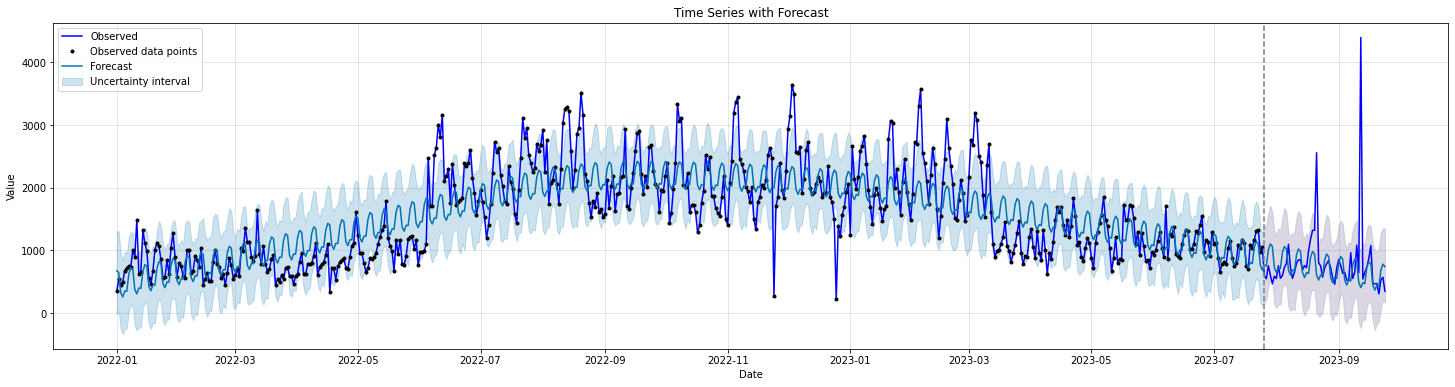

In [111]:
# x_limit_date ="2023-05-01"
# source_data = target_brand_data_fb[target_brand_data_fb['ds'] >= x_limit_date] .copy()
# forecast_data= forecast[forecast['ds'] >= x_limit_date] .copy()
fb_prophet_plot(target_brand_data_fb,forecast,tail_count=61)
# forecast_data.tail(62)
# forecast_data.head()

In [112]:
actual_df = target_brand_data_fb[target_brand_data_fb['ds'] >= pre_campaign_date][['ds','y']].reset_index(drop=True).copy()
predicted_df = forecast[forecast['ds'] >= pre_campaign_date][['ds','yhat']].reset_index(drop=True).copy()


In [113]:
predicted_df.head()

,ds,yhat
0,2023-07-26,766.437869
1,2023-07-27,749.955548
2,2023-07-28,1007.533884
3,2023-07-29,1102.166945
4,2023-07-30,1061.181773


In [114]:
combined_df = pd.merge(actual_df, predicted_df, on='ds')
combined_df.head()

,ds,y,yhat
0,2023-07-26,591.82,766.437869
1,2023-07-27,546.52,749.955548
2,2023-07-28,754.73,1007.533884
3,2023-07-29,603.64,1102.166945
4,2023-07-30,465.03,1061.181773


In [115]:
combined_df['daily_delta'] = round((combined_df['y'] - combined_df['yhat']),2)
combined_df.head()

,ds,y,yhat,daily_delta
0,2023-07-26,591.82,766.437869,-174.62
1,2023-07-27,546.52,749.955548,-203.44
2,2023-07-28,754.73,1007.533884,-252.80
3,2023-07-29,603.64,1102.166945,-498.53
4,2023-07-30,465.03,1061.181773,-596.15


In [116]:
round(combined_df['daily_delta'].sum(),2)

5081.54

In [55]:
def calculate_weekly_metrics(actual_df, predicted_df):
    
    combined_df = pd.merge(actual_df, predicted_df, on='ds')
    combined_df['ds'] = pd.to_datetime(combined_df['ds'])
    combined_df['week_start'] = combined_df['ds'] - pd.to_timedelta(combined_df['ds'].dt.dayofweek, unit='d')
    combined_df['week_end'] = combined_df['week_start'] + pd.DateOffset(days=6)
    
    weekly_counts = combined_df.groupby('week_start').size()
    incomplete_weeks = weekly_counts[weekly_counts < 7].index
    combined_df = combined_df[~combined_df['week_start'].isin(incomplete_weeks)]
    
    
    weekly_aggregated = combined_df.groupby('week_start').agg({'y': 'sum', 'yhat': 'sum', 'ds': 'count'}).reset_index()
    weekly_aggregated['week_delta'] = round((weekly_aggregated['y'] - weekly_aggregated['yhat']),2)
    weekly_aggregated['week_percentage'] = round((weekly_aggregated['week_delta'] / weekly_aggregated['y']) * 100,2)


    avg_weekly_delta = round(weekly_aggregated['week_delta'].mean(),2)
    avg_weekly_percentage = round(weekly_aggregated['week_percentage'].mean(),2)

    weekly_aggregated['cumulative_actual'] = round(weekly_aggregated['y'].cumsum(),2)
    weekly_aggregated['cumulative_predicted'] = round(weekly_aggregated['yhat'].cumsum(),2)
    weekly_aggregated['cumulative_delta'] = round(weekly_aggregated['week_delta'].cumsum(),2)
    weekly_aggregated['cumulative_percentage'] = round((weekly_aggregated['cumulative_delta'] / weekly_aggregated['cumulative_actual']) * 100,2)

    
    return weekly_aggregated, avg_weekly_delta, avg_weekly_percentage

In [56]:
weekly_aggregated, avg_weekly_delta, avg_weekly_percentage = calculate_weekly_metrics(actual_df, predicted_df)
print("*****************************")
print("*****************************")
print("avg_weekly_delta:",avg_weekly_delta, " || avg_weekly_percentage:" ,avg_weekly_percentage)
print("*****************************")
print("*****************************")
weekly_aggregated

*****************************
*****************************
avg_weekly_delta: -246.87  || avg_weekly_percentage: -5.31
*****************************
*****************************


,week_start,y,yhat,ds,week_delta,week_percentage,cumulative_actual,cumulative_predicted,cumulative_delta,cumulative_percentage
0,2023-07-24,13124.49,17608.035820,7,-4483.55,-34.16,13124.49,17608.04,-4483.55,-34.16
1,2023-07-31,13723.63,17001.348953,7,-3277.72,-23.88,26848.12,34609.38,-7761.27,-28.91
2,2023-08-07,19720.78,16394.662086,7,3326.12,16.87,46568.90,51004.05,-4435.15,-9.52
3,2023-08-14,17648.44,15787.975218,7,1860.46,10.54,64217.34,66792.02,-2574.69,-4.01
4,2023-08-21,15943.93,15181.288351,7,762.64,4.78,80161.27,81973.31,-1812.05,-2.26
5,2023-08-28,12718.24,14574.601484,7,-1856.36,-14.60,92879.51,96547.91,-3668.41,-3.95
6,2023-09-04,13604.23,13967.914616,7,-363.68,-2.67,106483.74,110515.83,-4032.09,-3.79
7,2023-09-11,18215.31,13361.227749,7,4854.08,26.65,124699.05,123877.05,821.99,0.66
8,2023-09-18,9710.69,12754.540882,7,-3043.85,-31.35,134409.74,136631.60,-2221.86,-1.65


In [107]:
weekly_aggregated.to_csv("chexmix_group_B10_17.csv",index=False)

# Statistical Regression

In [152]:
df_fb =df.copy()
df_fb = df_fb[df_fb['receipt_date'] <= '2023-09-25'] .copy()

date_col ="receipt_date"
brand="chex_mix"
target_brand_data_fb = df_fb[[date_col,brand]]
target_brand_data_fb = target_brand_data_fb.rename(columns={date_col: 'ds', brand: 'y'})
target_brand_data_fb.tail()

,ds,y
628,2023-09-21,942.96
629,2023-09-22,1749.27
630,2023-09-23,1951.29
631,2023-09-24,959.93
632,2023-09-25,1443.46


In [158]:
dat_wk=target_brand_data_fb[["ds","y"]].copy()
dat_wk['ds'] = pd.to_datetime(dat_wk['ds'])
dat_wk['week_start'] = dat_wk['ds'] - pd.to_timedelta(dat_wk['ds'].dt.dayofweek, unit='d')
dat_wk['week_end'] = dat_wk['week_start'] + pd.DateOffset(days=6)

weekly_counts = dat_wk.groupby('week_start').size()
incomplete_weeks = weekly_counts[weekly_counts < 7].index
dat_wk = dat_wk[~dat_wk['week_start'].isin(incomplete_weeks)]
dat_wk.tail(10)

,ds,y,week_start,week_end
622,2023-09-15,2138.66,2023-09-11,2023-09-17
623,2023-09-16,2572.34,2023-09-11,2023-09-17
624,2023-09-17,3063.43,2023-09-11,2023-09-17
625,2023-09-18,1578.55,2023-09-18,2023-09-24
626,2023-09-19,1346.46,2023-09-18,2023-09-24
627,2023-09-20,1182.23,2023-09-18,2023-09-24
628,2023-09-21,942.96,2023-09-18,2023-09-24
629,2023-09-22,1749.27,2023-09-18,2023-09-24
630,2023-09-23,1951.29,2023-09-18,2023-09-24
631,2023-09-24,959.93,2023-09-18,2023-09-24


In [159]:
weekly_sales = dat_wk.groupby('week_start')['y'].sum().reset_index()
weekly_sales.tail(10)

,week_start,y
80,2023-07-17,20516.02
81,2023-07-24,13124.49
82,2023-07-31,13723.63
83,2023-08-07,19720.78
84,2023-08-14,17648.44
85,2023-08-21,15943.93
86,2023-08-28,12718.24
87,2023-09-04,13604.23
88,2023-09-11,18215.31
89,2023-09-18,9710.69


In [160]:
week_ofset_val=9


last_weeks = weekly_sales['week_start'].max() - pd.DateOffset(weeks=week_ofset_val)  # Get the marketing weeks


weekly_sales['marketing'] = (weekly_sales['week_start'] >= last_weeks).astype(int)


weekly_sales.tail(15)

,week_start,y,marketing
75,2023-06-12,21440.59,0
76,2023-06-19,20636.87,0
77,2023-06-26,20081.99,0
78,2023-07-03,17863.99,0
79,2023-07-10,19895.57,0
80,2023-07-17,20516.02,1
81,2023-07-24,13124.49,1
82,2023-07-31,13723.63,1
83,2023-08-07,19720.78,1
84,2023-08-14,17648.44,1


In [161]:
df_reg=weekly_sales.copy()

# ols regression
X = df_reg['marketing']  
X = sm.add_constant(X)  
y = df_reg['y'] 



model = sm.OLS(y, X).fit()


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     12.53
Date:                Tue, 20 Feb 2024   Prob (F-statistic):           0.000642
Time:                        23:08:40   Log-Likelihood:                -952.61
No. Observations:                  90   AIC:                             1909.
Df Residuals:                      88   BIC:                             1914.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.697e+04   1081.171     24.949      0.0

In [40]:
forecast_df = sf.predict(h=60, level=[90])
forecast_df.tail()

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90
unique_id,,,,
chec_mix,2023-09-22,2570.150879,288.000824,4852.300781
chec_mix,2023-09-23,2570.239746,279.932159,4860.547363
chec_mix,2023-09-24,2571.273193,272.843903,4869.702637
chec_mix,2023-09-25,2570.665771,264.147125,4877.184570
chec_mix,2023-09-26,2570.692871,256.114990,4885.270996


/opt/conda/lib/python3.7/site-packages/statsforecast/core.py:1514: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["unique_id"] = df["unique_id"].astype(uid_dtype)


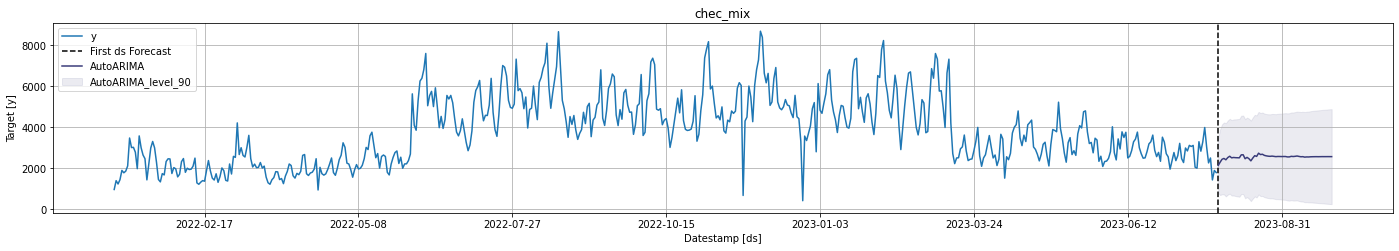

In [41]:
sf.plot(train_data, forecast_df, level=[90])

In [43]:
aaprophet = AutoARIMAProphet()
aaprophet.fit(train_data[["ds","y"]], disable_seasonal_features=False)

/opt/conda/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/opt/conda/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [44]:
aap_pred = aaprophet.make_future_dataframe(periods=60)
aap_pred = aaprophet.predict(aap_pred)

In [54]:
model = Prophet()
model.fit(train_data[["ds","y"]])
future = model.make_future_dataframe(periods=60)
forecast = model.predict(future)

00:43:59 - cmdstanpy - INFO - Chain [1] start processing
00:43:59 - cmdstanpy - INFO - Chain [1] done processing


In [55]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-01-01,1442.787938,659.739571,3434.152477,1442.787938,1442.787938,567.250008,567.250008,567.250008,567.250008,567.250008,567.250008,0.0,0.0,0.0,2010.037946
1,2022-01-02,1455.362274,598.846816,3353.123140,1455.362274,1455.362274,515.002883,515.002883,515.002883,515.002883,515.002883,515.002883,0.0,0.0,0.0,1970.365158
2,2022-01-03,1467.936611,-206.410138,2428.323993,1467.936611,1467.936611,-285.811474,-285.811474,-285.811474,-285.811474,-285.811474,-285.811474,0.0,0.0,0.0,1182.125137
3,2022-01-04,1480.510947,-394.382945,2319.899956,1480.510947,1480.510947,-559.558229,-559.558229,-559.558229,-559.558229,-559.558229,-559.558229,0.0,0.0,0.0,920.952718
4,2022-01-05,1493.085284,-119.175259,2514.836075,1493.085284,1493.085284,-281.754478,-281.754478,-281.754478,-281.754478,-281.754478,-281.754478,0.0,0.0,0.0,1211.330805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,2023-09-22,1715.174831,662.932658,3440.329416,1600.715728,1833.633870,315.397935,315.397935,315.397935,315.397935,315.397935,315.397935,0.0,0.0,0.0,2030.572766
630,2023-09-23,1702.237013,963.656912,3558.877526,1584.477093,1823.790592,567.250008,567.250008,567.250008,567.250008,567.250008,567.250008,0.0,0.0,0.0,2269.487021
631,2023-09-24,1689.299195,783.973791,3524.791959,1567.992975,1813.338392,515.002883,515.002883,515.002883,515.002883,515.002883,515.002883,0.0,0.0,0.0,2204.302078
632,2023-09-25,1676.361376,38.586592,2912.260163,1551.370260,1803.161865,-285.811474,-285.811474,-285.811474,-285.811474,-285.811474,-285.811474,0.0,0.0,0.0,1390.549902


In [47]:
target_brand_data_fb.tail()

,unique_id,ds,y
629,chec_mix,2023-09-22,1749.27
630,chec_mix,2023-09-23,1951.29
631,chec_mix,2023-09-24,959.93
632,chec_mix,2023-09-25,1443.46
633,chec_mix,2023-09-26,1339.99


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
# Plot the observed data
plt.plot(target_brand_data_fb['ds'], target_brand_data_fb['y'], label='Observed', color='blue')

# Plot the forecasted values
aaprophet.plot(aap_pred, ax=plt.gca())

# Find the index where the projection starts
projection_start_idx = target_brand_data_fb[target_brand_data_fb['ds'] == aap_pred['ds'].tail(60).iloc[0]].index[0]

# Plot a vertical dotted line at the projection start point
plt.axvline(x=target_brand_data_fb['ds'].iloc[projection_start_idx], linestyle='--', color='gray')

# Plot the projected data in pink color
plt.fill_between(aap_pred['ds'].tail(60), aap_pred['yhat_lower'].tail(60), aap_pred['yhat_upper'].tail(60), color='pink', alpha=0.3)



# Plot formatting
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series with Forecast')
plt.legend(loc='upper left')
plt.show()

In [62]:
# forecast.tail(60).iloc[0]].index[0]
target_brand_data_fb[target_brand_data_fb['ds'] == forecast['ds'].tail(60).iloc[0]].index[0]

574

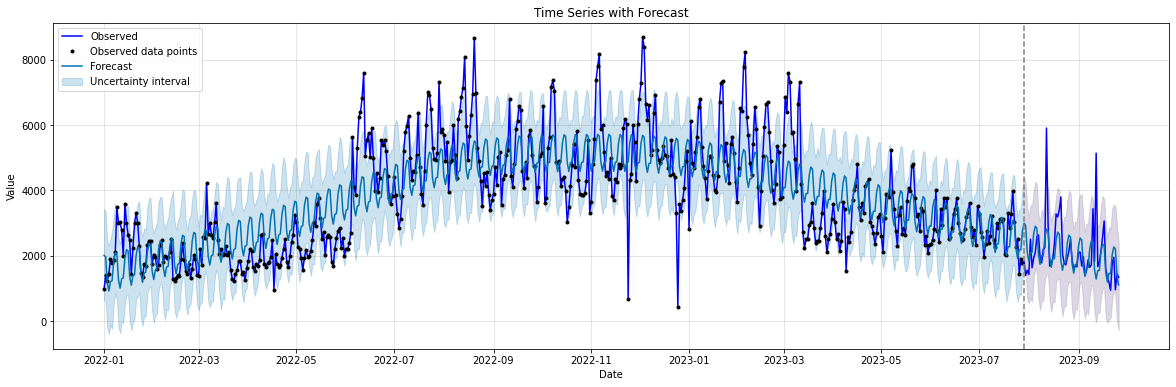

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
# Plot the observed data
plt.plot(target_brand_data_fb['ds'], target_brand_data_fb['y'], label='Observed', color='blue')

# Plot the forecasted values
aaprophet.plot(forecast, ax=plt.gca())


# Find the index where the projection starts
projection_start_idx = target_brand_data_fb[target_brand_data_fb['ds'] == forecast['ds'].tail(60).iloc[0]].index[0]

# Plot a vertical dotted line at the projection start point
plt.axvline(x=target_brand_data_fb['ds'].iloc[projection_start_idx], linestyle='--', color='gray')

# Plot the projected data in pink color
plt.fill_between(forecast['ds'].tail(60), forecast['yhat_lower'].tail(60), forecast['yhat_upper'].tail(60), color='pink', alpha=0.3)



# Plot formatting
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series with Forecast')
plt.legend(loc='upper left')
plt.show()

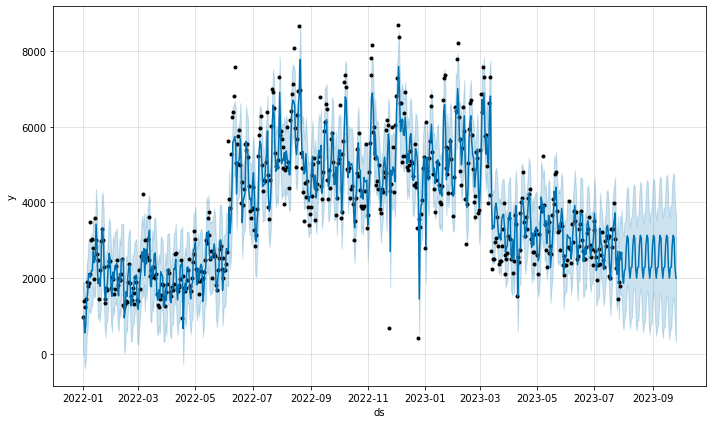

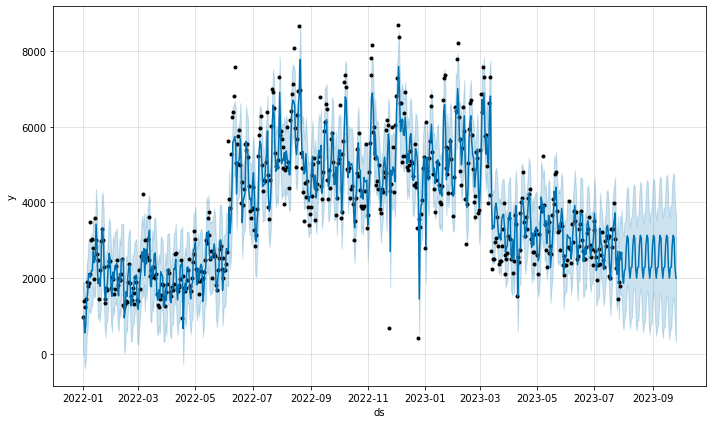

In [46]:
aaprophet.plot(aap_pred)

In [ ]:
import matplotlib.pyplot as plt

# Assuming `data` contains your entire time series data, including the future dates
# and `forecast` contains the predicted values generated by Prophet

# Plot the observed data
plt.plot(data['ds'], data['y'], label='Observed', color='blue')

# Plot the forecasted values
prophet_model.plot(forecast, ax=plt.gca())

# Plot formatting
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series with Forecast')
plt.legend(loc='upper left')
plt.show()

In [32]:
target_brand_data_fb['unique_id']="chec_mix"

In [24]:
target_brand_data_fb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      634 non-null    datetime64[ns]
 1   y       634 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.0 KB


In [25]:
train_data

0       969.84
1      1399.96
2      1238.09
3      1445.96
4      1900.17
        ...   
569    2265.38
570    2503.96
571    1435.54
572    1896.54
573    1792.44
Name: y, Length: 574, dtype: float64

In [19]:
data=target_brand_data_fb.copy()

In [22]:
model = AutoARIMA()
model.fit(train_data)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mnon-precise type pyobject[0m
[0m[1mDuring: typing of argument at /opt/conda/lib/python3.7/site-packages/statsforecast/arima.py (565)[0m
[1m
File "../../opt/conda/lib/python3.7/site-packages/statsforecast/arima.py", line 565:[0m
[1mdef diff1d(x, lag, differences):
[1m    y = x.copy()
[0m    [1m^[0m[0m 

This error may have been caused by the following argument(s):
- argument 0: [1mCannot determine Numba type of <class 'pandas.core.series.Series'>[0m


In [21]:
from statsforecast.models import AutoARIMA
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Split your 15 months data into train and validation sets
train_data = data['y'].iloc[:-60]  # First 15 months of data
validation_data = data['y'].iloc[-120:-60]  # Second to last 60 days for validation
test_data = data['y'].iloc[-60:]  # Last 60 days for testing

# Perform parameter tuning using Time Series Cross-Validation (CV)
tscv = TimeSeriesSplit(n_splits=5)  # You can adjust the number of splits as needed
best_mape = np.inf
best_order = None

for train_index, val_index in tscv.split(train_data):
    train_split, val_split = train_data.iloc[train_index], train_data.iloc[val_index]
    model = AutoARIMA()
    model.fit(train_split)
    forecast = model.predict(steps=len(val_split))
    mape = mean_absolute_percentage_error(val_split, forecast)
    if mape < best_mape:
        best_mape = mape
        best_order = model.get_params()['order']

print("Best MAPE:", best_mape)
print("Best order:", best_order)

# Retrain the model using the best parameters on the entire training set
final_model = AutoARIMA(order=best_order)
final_model.fit(train_data)

# Make predictions for the last 60 days
final_forecast = final_model.predict(steps=len(test_data))

# Evaluate the model's performance on the test set
final_mape = mean_absolute_percentage_error(test_data, final_forecast)
print("Final MAPE:", final_mape)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mnon-precise type pyobject[0m
[0m[1mDuring: typing of argument at /opt/conda/lib/python3.7/site-packages/statsforecast/arima.py (331)[0m
[1m
File "../../opt/conda/lib/python3.7/site-packages/statsforecast/arima.py", line 331:[0m
[1mdef arima_css(y, arma, phi, theta, ncond):
[1m    n = len(y)
[0m    [1m^[0m[0m 

This error may have been caused by the following argument(s):
- argument 0: [1mCannot determine Numba type of <class 'pandas.core.series.Series'>[0m


In [66]:
target_brand_data_fb.head()

,unique_id,ds,y
0,chec_mix,2022-01-01,969.84
1,chec_mix,2022-01-02,1399.96
2,chec_mix,2022-01-03,1238.09
3,chec_mix,2022-01-04,1445.96
4,chec_mix,2022-01-05,1900.17


,ds,y,week_start
0,2022-01-01,969.84,2021-12-27
1,2022-01-02,1399.96,2021-12-27
2,2022-01-03,1238.09,2022-01-03
3,2022-01-04,1445.96,2022-01-03
4,2022-01-05,1900.17,2022-01-03


,week_start,y
0,2021-12-27,2369.80
1,2022-01-03,13824.84
2,2022-01-10,20034.09
3,2022-01-17,17718.74
4,2022-01-24,13475.41


In [70]:
weekly_sales.iloc[1:-2].tail(12)

NameError: name 'weekly_sales' is not defined

In [74]:
weekly_sales['marketing'] = (weekly_sales['week_start'] >= last_9_weeks).astype(int)

In [84]:
df_reg=weekly_sales.iloc[1:-2].copy()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     9.863
Date:                Fri, 16 Feb 2024   Prob (F-statistic):            0.00230
Time:                        03:12:19   Log-Likelihood:                -942.42
No. Observations:                  89   AIC:                             1889.
Df Residuals:                      87   BIC:                             1894.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.689e+04   1079.482     24.914      0.0

In [89]:
# Check the p-value associated with the 'marketing_campaign' coefficient
if model.pvalues['marketing'] < 0.05:
    print("Reject the null hypothesis: The marketing campaign has a significant effect on sales.")
else:
    print("Fail to reject the null hypothesis: There is insufficient evidence to conclude that the marketing campaign has a significant effect on sales.")

Reject the null hypothesis: The marketing campaign has a significant effect on sales.


In [10]:
df.tail()

,receipt_date,weekend,motts,nv_protein_bar,nv_crunchy_bar,gmi_cereal_bars,larabar_orig,gardettos,muddy_buddies,bugles,chex_mix
724,2023-12-26,0,549.41,344.27,496.87,191.43,368.62,414.62,315.13,276.74,1359.49
725,2023-12-27,0,1159.38,413.35,769.99,197.72,302.86,443.89,213.31,328.28,1269.94
726,2023-12-28,0,1099.82,427.90,654.87,227.76,435.94,577.86,293.07,278.27,1717.38
727,2023-12-29,0,1398.85,526.59,757.67,235.58,352.83,1000.72,466.93,586.43,2544.26
728,2023-12-30,1,1571.79,912.37,1040.13,309.46,456.46,866.72,357.35,564.87,2470.23


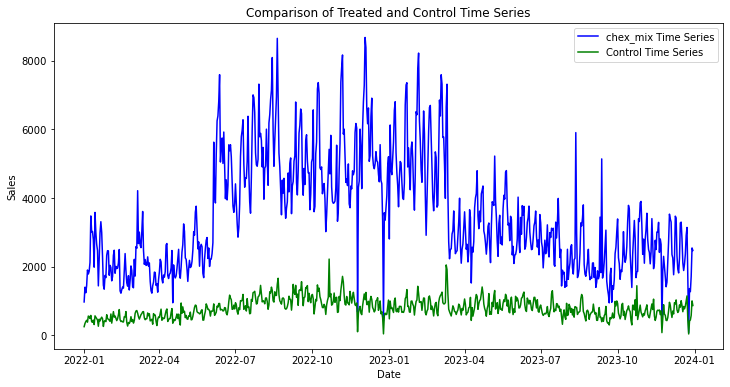

<Figure size 864x576 with 0 Axes>

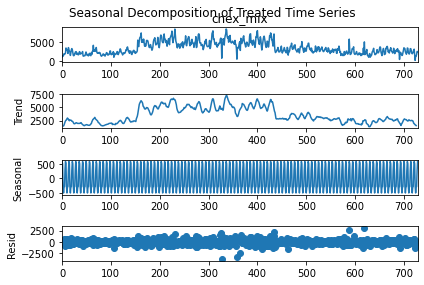

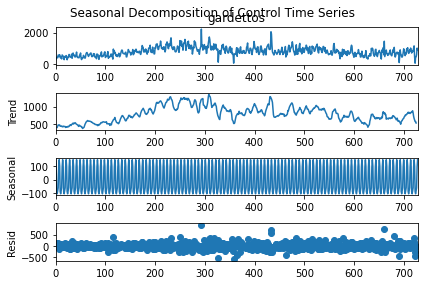

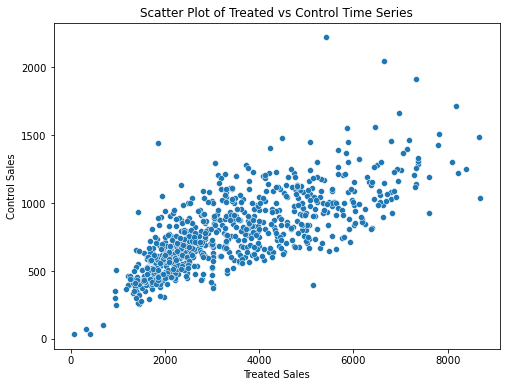

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Assuming you have loaded the treated and control time series data into pandas DataFrames
# Replace 'treated_df' and 'control_df' with your actual DataFrames

# Plotting the time series data
plt.figure(figsize=(12, 6))

# Plot treated time series
plt.plot(df['receipt_date'], df['chex_mix'], label='chex_mix Time Series', color='blue')

# Plot control time series
plt.plot(df['receipt_date'], df['gardettos'], label='Control Time Series', color='green')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Comparison of Treated and Control Time Series')
plt.legend()
plt.show()

# Plotting seasonal decomposition
plt.figure(figsize=(12, 8))

# Seasonal decomposition for treated time series
decomposition_treated = sm.tsa.seasonal_decompose(df['chex_mix'], model='additive', period=7)  # Assuming weekly seasonality
decomposition_treated.plot().suptitle('Seasonal Decomposition of Treated Time Series')

# Seasonal decomposition for control time series
decomposition_control = sm.tsa.seasonal_decompose(df['gardettos'], model='additive', period=7)  # Assuming weekly seasonality
decomposition_control.plot().suptitle('Seasonal Decomposition of Control Time Series')

plt.show()

# Plotting scatter plot for correlation
plt.figure(figsize=(8, 6))

# Scatter plot
sns.scatterplot(data=pd.merge(df[['receipt_date','chex_mix']], df[['receipt_date','gardettos']], on='receipt_date'), x='chex_mix', y='gardettos')
plt.title('Scatter Plot of Treated vs Control Time Series')
plt.xlabel('Treated Sales')
plt.ylabel('Control Sales')
plt.show()

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import correlate
from scipy.signal import coherence
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from dtw import dtw

In [34]:
treated_series=np.array(df['chex_mix'])
control_series=np.array(df['gardettos'])

In [33]:
def normalize(data):
    return (data - data.min()) / (data.max() - data.min())

In [35]:
# scaler = MinMaxScaler()
treated_normalized = normalize(treated_series)
control_normalized = normalize(control_series)


In [37]:
correlation = np.corrcoef(treated_normalized, control_normalized)[0, 1]
mse = np.mean((treated_normalized - control_normalized) ** 2)
# Cross-correlation
cross_corr = correlate(treated_normalized, control_normalized)

# Spectral Coherence
f, coh = coherence(treated_normalized, control_normalized, fs=1.0)

# Dynamic Time Warping
fdtw_distance, _ = fastdtw(treated_normalized, control_normalized, dist=euclidean)
distance, _, _ ,_ = dtw(treated_normalized,control_normalized, dist=lambda x, y: np.sqrt(np.sum((x - y) ** 2)))

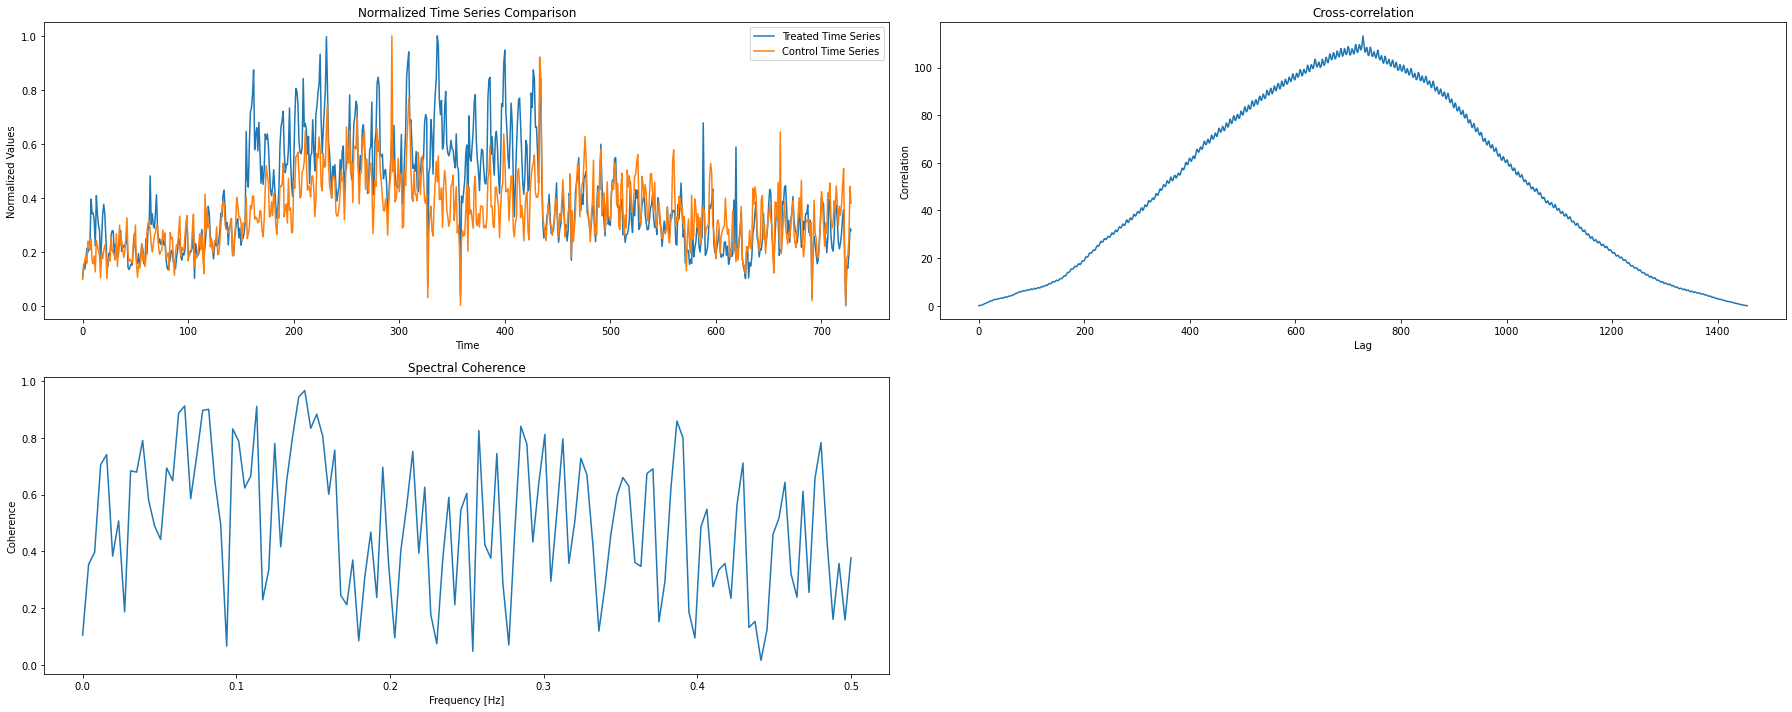

In [42]:
# Visualize normalized time series
plt.figure(figsize=(25, 10))
plt.subplot(2, 2, 1)
plt.plot(treated_normalized, label='Treated Time Series')
plt.plot(control_normalized, label='Control Time Series')
plt.xlabel('Time')
plt.ylabel('Normalized Values')
plt.title('Normalized Time Series Comparison')
plt.legend()


# Visualize cross-correlation
plt.subplot(2, 2, 2)
plt.plot(cross_corr, label='Cross-correlation')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title('Cross-correlation')

# Visualize Spectral Coherence
plt.subplot(2, 2, 3)
plt.plot(f, coh, label='Spectral Coherence')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence')
plt.title('Spectral Coherence')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Spectral Coherence')

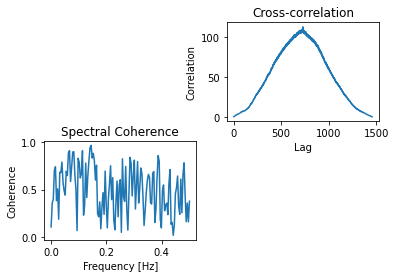

In [45]:

print("Correlation Coefficient:", correlation)
print("Mean Squared Error:", mse)
print("DTW Distance:", distance)

Correlation Coefficient: 0.7384383960584725
Mean Squared Error: 0.019284777749065254
DTW Distance: 47.898425694087514


In [1]:
!pip install dowhy

     |████████████████████████████████| 287 kB 1.3 MB/s            
     |████████████████████████████████| 6.4 MB 21.4 MB/s            
     |████████████████████████████████| 536 kB 35.2 MB/s            


In [ ]:
import dowhy
from dowhy import CausalModel

# Define causal model with propensity score as a covariate
model = CausalModel(
    data=data,
    treatment='exposure_to_ad',
    outcome='amount_spent_on_advertised_product',
    common_causes=['past_transaction_values', 'unique_products_bought', 'propensity_score']
)

# Estimate causal effect using propensity score matching
estimate = model.estimate_effect(method_name="backdoor.propensity_score_matching")

# Evaluate results
print(estimate)

# Classify users
# For example, classify users as responders based on estimated treatment effect
data['responders'] = data['amount_spent_on_advertised_product'] > estimate.value